In [3]:
import sys
import matplotlib.pyplot as plt
import numpy as np

import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
from pyro.infer import Trace_ELBO

sys.path.append("../../sbo")

import sbo
import utilities

## Target function

In [4]:
class BraninHooTarget(sbo.TargetFunction):
    
    def eval(self, x):
        
        """ Compute Branin-Hoo function for fixed constants """
        a = 1.0
        b = 5.1 / (4 * np.pi**2)
        c = 5.0 / np.pi
        r = 6.0
        s = 10.0
        t = 1.0 / (8 * np.pi)
        x1 = x[...,0]
        x2 = x[...,1]
        
        return a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1 - t)*torch.cos(x1) + s

target = BraninHooTarget([[-5, 10], [0, 15]])

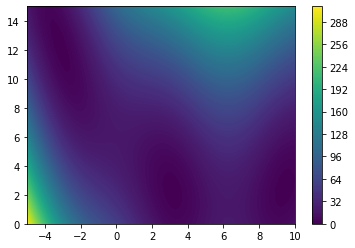

In [5]:
utilities.plot2d_func(target.eval, target.ranges)
plt.savefig('bh_landscape.png', dpi=300)

## Training data

In [3]:
utilities.set_random_seed(555)

In [4]:
N_train_points = 5

X_train = torch.rand(N_train_points, 2)*15 + torch.FloatTensor([target.ranges[0][0], target.ranges[1][0]])

y_train = target.eval(X_train)

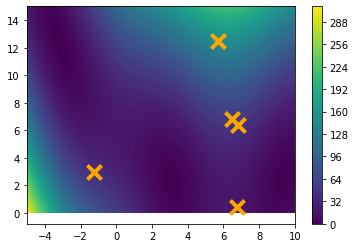

In [5]:
utilities.plot2d_func(target.eval, target.ranges)
plt.scatter(X_train[:,0].detach().numpy(), X_train[:,1].detach().numpy(), 
            marker="x", s=200, c='orange', zorder=2, linewidth=4);

## Parametric model

In [6]:
class ParametricMeanFn(PyroModule):
    
    def __init__(self):
        super().__init__()
        
        self.alpha = PyroSample(dist.Uniform(0, 20))
        self.beta = PyroSample(dist.Uniform(0, 20))
        self.gamma = PyroSample(dist.Uniform(0, 20))
        
    def forward(self, X):

        x1 = X[...,0]
        x2 = X[...,1]
        return self.alpha*torch.cos(x1) + self.beta*torch.pow(x1, 4) + torch.pow(x2, 2) + self.gamma

## SBO

In [7]:
pyro.clear_param_store()

# SBO parameters
sbo_steps = 20

opti_num_steps = 1000
opti_params = {"lr": 0.1}
optimizer = pyro.optim.Adam(opti_params)
loss = Trace_ELBO()

return_site = "EI"

# Acquisition function optimizer
acqf_optimizer = torch.optim.Adam
acqf_opti_num_steps = 100
acqf_opti_lr = 0.5

num_candidates = 10

# Sampling
num_samples = 5

In [8]:
# GP kernel
kernel = gp.kernels.Matern52(
    input_dim = X_train.shape[1], lengthscale = 10*torch.ones(X_train.shape[1]))

# Semi paramteric GP model
model = sbo.SemiParametricModel(X_train, y_train, ParametricMeanFn(), kernel)

# Defining GP's parameters
model.gp.kernel.lengthscale = PyroSample(dist.Uniform(0, 15).expand([X_train.shape[1]]).to_event())
model.gp.kernel.variance = PyroSample(dist.Uniform(0, 50))
model.gp.noise = PyroSample(dist.Uniform(0, 1))

guide = None

SBO step: 0 tensor([6.8361, 6.4078])


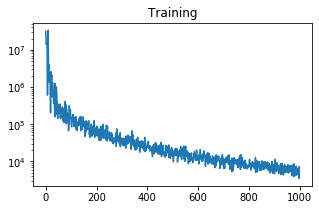

SBO step: 1 tensor([1.3336, 0.0331])


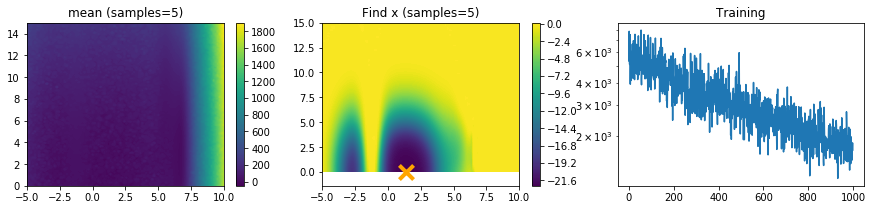

SBO step: 2 tensor([2.7809, 0.0364])


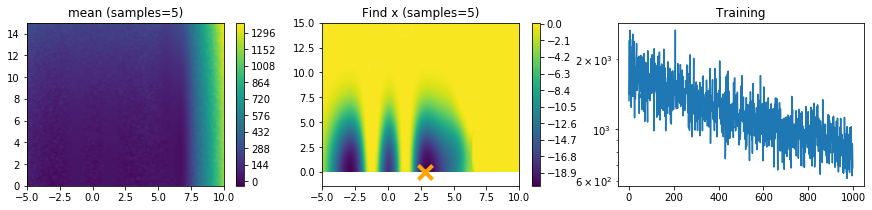

SBO step: 3 tensor([-2.8007e+00,  2.4403e-03])


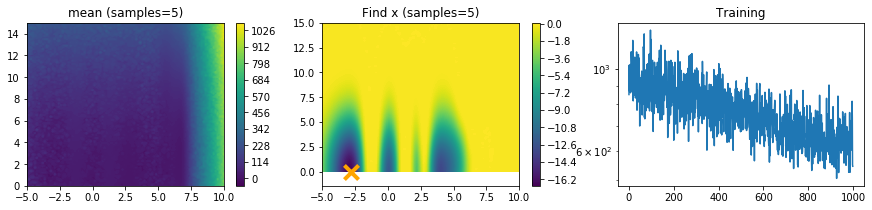

SBO step: 4 tensor([4.0701, 0.0223])


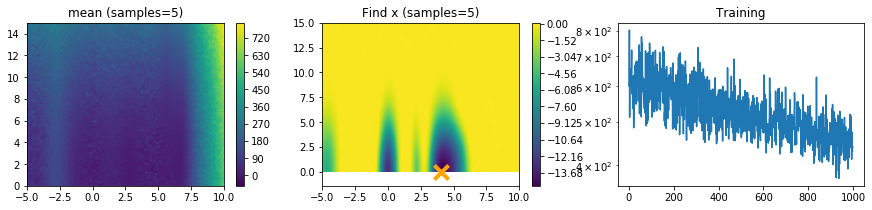

SBO step: 5 tensor([5.1219, 0.1641])


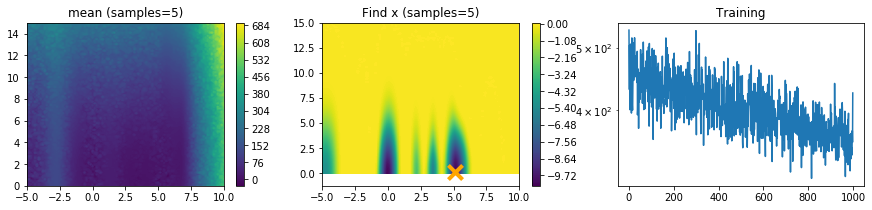

SBO step: 6 tensor([-0.0324,  0.0099])


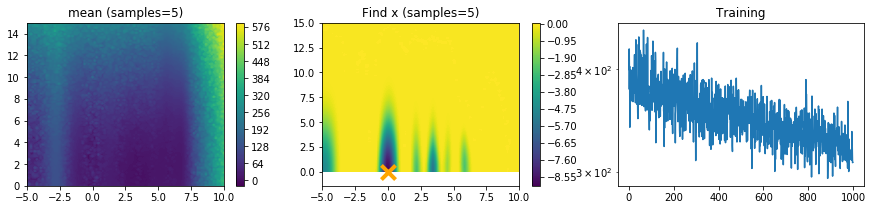

SBO step: 7 tensor([-4.9756e+00,  2.3411e-03])


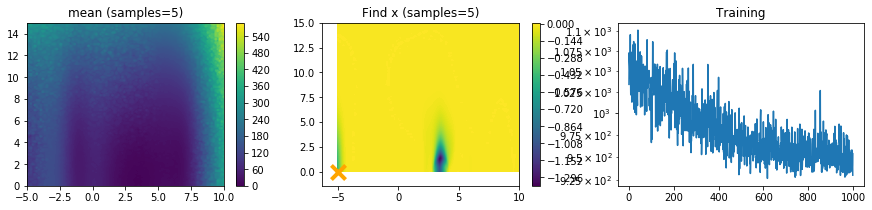

SBO step: 8 tensor([3.4071, 0.0774])


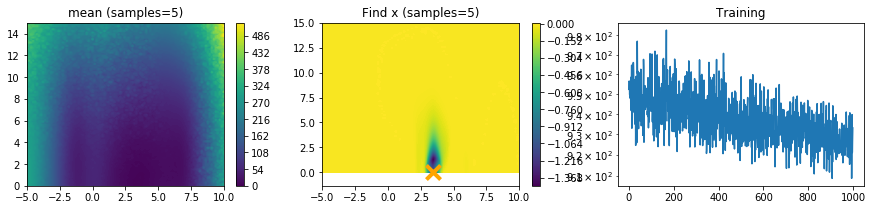

SBO step: 9 tensor([8.1934, 0.1128])


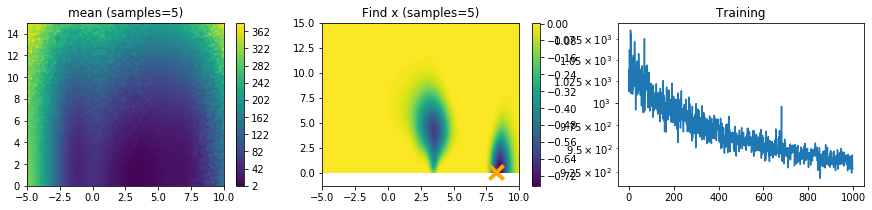

SBO step: 10 tensor([3.4454, 2.7434])


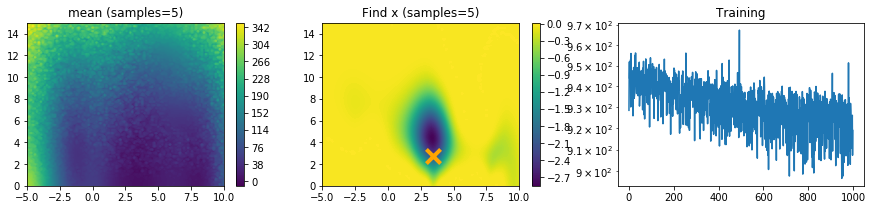

SBO step: 11 tensor([9.7013, 1.3193])


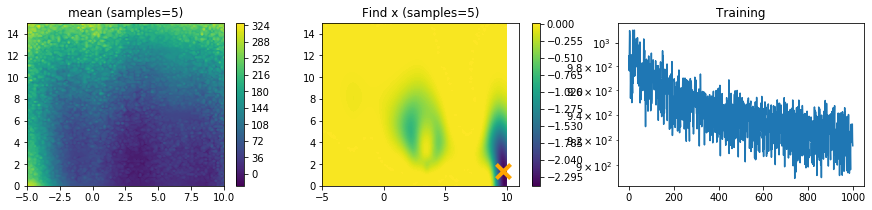

SBO step: 12 tensor([3.2902, 4.6301])


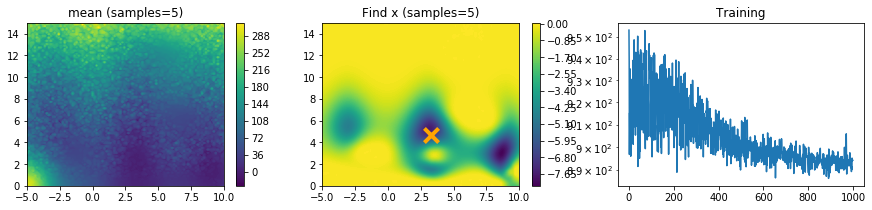

SBO step: 13 tensor([8.6768, 3.2113])


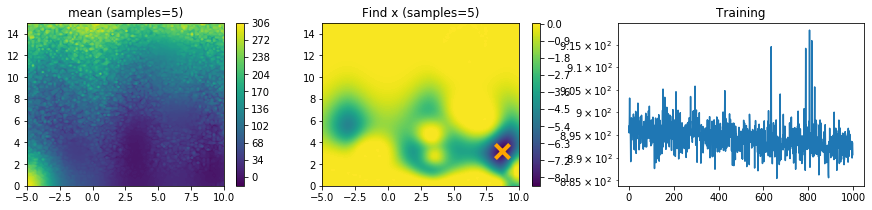

SBO step: 14 tensor([1.9730, 3.0653])


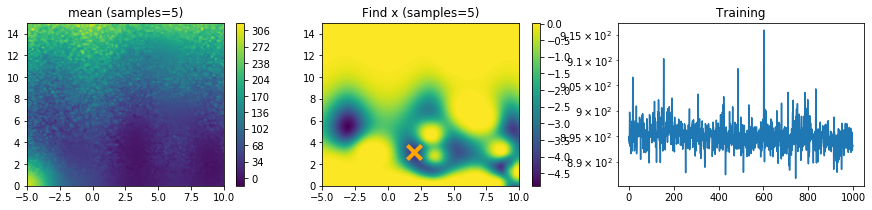

SBO step: 15 tensor([-3.0901,  5.2000])


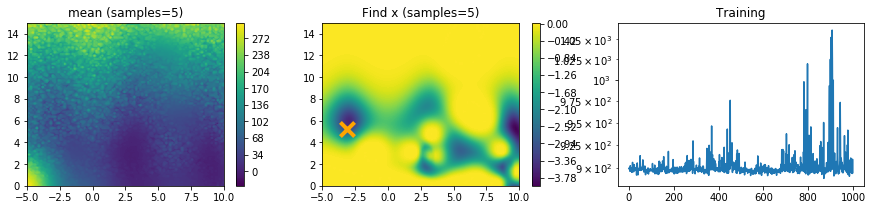

SBO step: 16 tensor([9.9461, 5.2814])


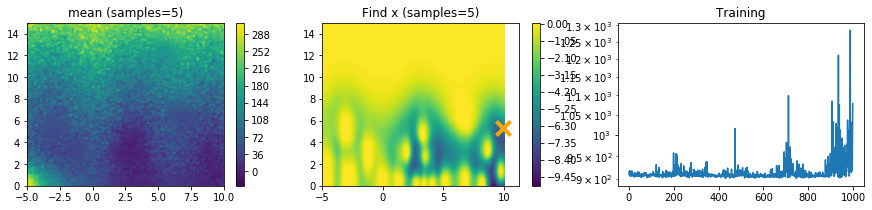

SBO step: 17 tensor([9.8491, 3.2268])


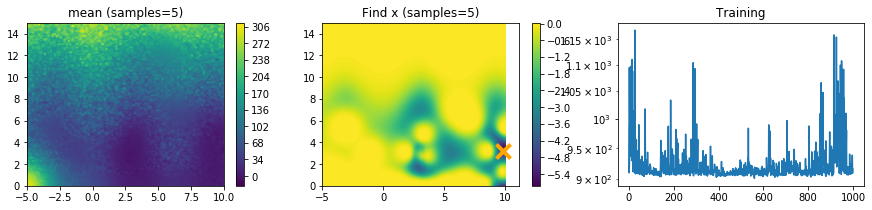

SBO step: 18 tensor([9.9894e+00, 3.7613e-04])


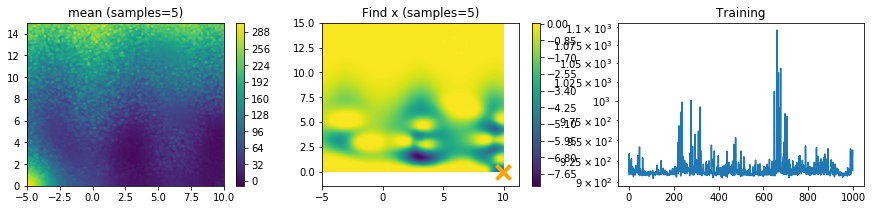

SBO step: 19 tensor([2.8680, 1.8258])


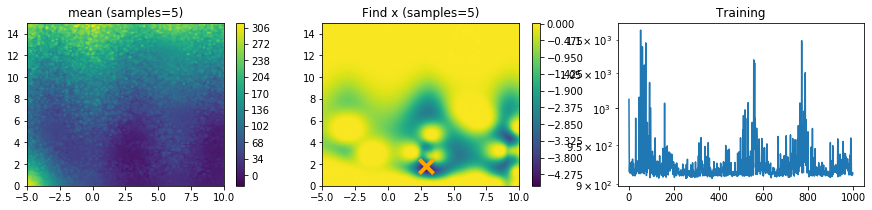

In [9]:
for i in range(sbo_steps):
    
    guide, predict, losses = sbo.step(model, guide, optimizer, loss, target, acqf_optimizer, 
                                      opti_num_steps=opti_num_steps, acqf_opti_num_steps=acqf_opti_num_steps,
                                      acqf_opti_lr=acqf_opti_lr, num_samples=num_samples, 
                                      num_candidates=num_candidates,
                                      return_site=return_site)
            
    ######################
    # Visualising the step
    ######################
    if i == 0:
        plt.figure(figsize=(5, 3))
        
        plt.title("Training")
        plt.semilogy(losses)
        
    else:
        plt.figure(figsize=(15, 3))
        
        plt.subplot(1,3,1)
        plt.title("mean (samples=%d)" % (num_samples))
        
        with torch.no_grad():
            utilities.plot2d_func(lambda x: predict(x)["y"].mean(0), target.ranges)
        
        plt.subplot(1,3,2)
        plt.title("Find x (samples=%d)" % (num_samples))
        
        with torch.no_grad():
            utilities.plot2d_func(lambda x: predict(x)[return_site].mean(0), target.ranges)
        
        plt.scatter(model.X[-1, 0].detach().numpy(), model.X[-1, 1].detach().numpy(), 
            marker="x", s=200, c='orange', zorder=2, linewidth=4);
        
        plt.subplot(1,3,3)
        plt.title("Training")
        plt.semilogy(losses)
    
    plt.show()
    
    print("SBO step: %d" % (i), model.X[-1])